# Kuramoto Model

## Introduction

### Deep Brain Stimulation (DBS)

Brain disorders are thought to arise from dysfunctional signaling within complex brain networks. Deep brain stimulation (DBS) is the direct electrical stimulation of deep regions of the brain through surgically implanted electrodes. Despite the lack of any clear, quantitative model of brain signaling in diseases, particularly psychiatric diseases, the demonstrated efficacy of DBS is substantial.

### Network Oscillatory Activity

Electrical field potentials generated by large populations of sychronously firing neurons demonstrate strongly oscillatory components. Much of modern human-subject electrophysiology revolves around fourier-domain techniques for oscillatory power characterization.

### Kuramoto Model

Deep brain stimulation (DBS) is direct stimulation of brain networks in order to treat neurological and psychiatric illnesses. Studying DBS effects directly in patients provides deeper insights into disease processes than animal models, but comes with major limitations. Computational models can bridge human subject electrophysiology with basic science by providing generative models for hypothesis testing approaches like dynamic causal modeling. Here, we present one such generative model built on networked kuramoto oscillators.


In [371]:
%reset
%matplotlib inline
import networkx as nx
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Creating the Model

### Structure
The underlying structure of a basic Kuramoto model is:   
$
\begin{equation}
\dot{\phi_i} = \omega_i + \frac{K}{N} \sum\limits_{j \in N_i} f(\phi_j - \phi_i)
\end{equation}
$

Using the graphical formulation of the Kuramoto Model, we get:  
$
\begin{equation}
\dot{\vec{\phi}} = \vec{\omega} + D sin( D^T \vec{\phi})
\end{equation}
$


In [691]:
class KModel:
    def __init__(self,l = 1, u = .1):
        #Graph
        nodes = [1,2,3,4,5,6]
        self.G = nx.Graph()
        self.G.add_nodes_from(nodes)
        self.G.add_edges_from([(1,2),(2,3),(1,3),(3,4),(4,5),(4,6),(5,6)])
        
        self.states = np.matrix(np.random.uniform(-np.pi/2,np.pi/2,[len(nodes),1])) #memory of phases
        self.w = np.matrix(np.random.normal(l,u,[len(nodes),1])) #initial intrinsic freq.
        self.K = 1 #Coupling constant
        self.ef = np.sin #edge function
        self.t = 0 #time
        self.dt = .1 #time step
        
    def phase_dev(self,phase):
        D = (nx.incidence_matrix(self.G, oriented = True)).todense()
        W = self.edge_w()
        E = self.edge_func(W*D.T)
        return self.int_frq() + self.K/len(self.G) * D * E
    
    def euler_step(self):
        new_state = self.states[:,-1] + self.phase_dev(self.states[:,-1])*self.dt
        new_state = new_state % (2 * np.pi)
        self.t += self.dt
        self.states = np.hstack((self.states,new_state))
        
    def runge_kutta_step(self):
        k1 = self.phase_dev(self.states[:,-1])*self.dt
        k2 = self.phase_dev(self.states[:,-1]+ .5*k1)*self.dt
        k3 = self.phase_dev(self.states[:,-1]+ .5*k2)*self.dt
        k4 = self.phase_dev(self.states[:,-1]+ k3)*self.dt
        new_state = self.states[:,-1] + (k1+ 2*k2 + 2*k3 + k4)/6
        new_state = new_state % (2 * np.pi)
        self.t += self.dt
        self.states = np.hstack((self.states,new_state))
            
    def step(self):
        self.euler_step()
        
    def coh_func(self,coherence):
        c1 = 1/(coherence+1)
        c2 = 1 - c1
        A = np.sqrt(c1**2+c2**2)
        offset = np.arctan(c1/c2)
        def comb_sin_cos(x):
            A*np.sin(x+np.ones(x.shape)*offset)
        return comb_sin_cos
    
    def edge_w(self):
        weights = [1]*nx.number_of_edges(self.G)
        return np.diag(weights)
    
    def edge_func(self,M):
        PDiff = M * self.states[:,-1]
        PDiff = PDiff.tolist()
        vf = [self.ef]*nx.number_of_edges(self.G)
        e = [(vf[x](PDiff[x])).tolist() for x in range(0,len(vf))]
        return np.matrix(e)   
    
    def int_frq(self):
        return self.w

We can see how the nodes dynamically behave through generating the time steps

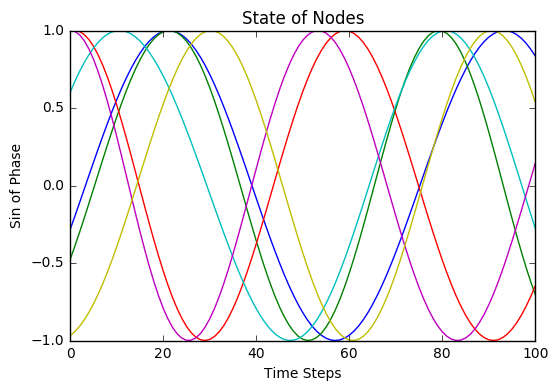

In [697]:
def time_course():
    K = KModel()
    time = 10
    
    for ts in range(0,int(time/K.dt)):
        K.step()
        
    plt.figure()
    plt.plot(np.sin(K.states.T))
    plt.xlabel('Time Steps')
    plt.ylabel('Sin of Phase')
    plt.title('State of Nodes')
    plt.xlim((0,int(time/K.dt)))
    plt.show()
time_course()

A View of the Network

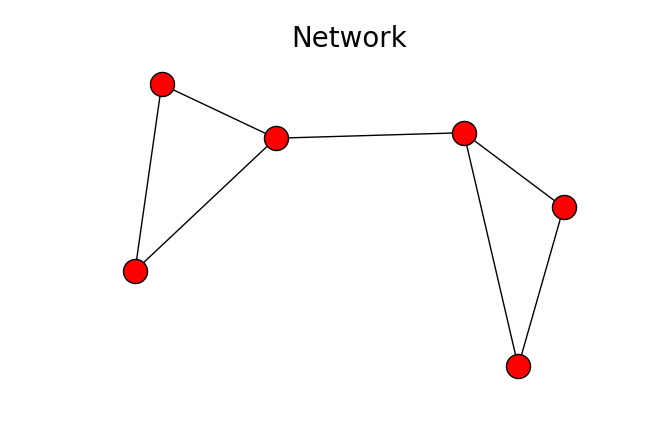

In [470]:
def network():
    K = KModel()
    fig = plt.figure()
    fig.suptitle('Network', fontsize=20)
    nx.draw(K.G)
network()

Looking at the initial phases

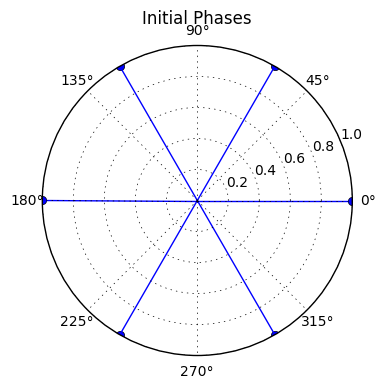

In [469]:
def phaseplot():
    K = KModel()    
    plt.figure()
    ax = plt.subplot(111,projection='polar')
    ax.stem(K.states,np.ones(K.states.shape))
    ax.set_title('Initial Phases')
    ax.set_rmax(1)
    plt.show()
phaseplot()

A much better view,
seeing the animation in real time

<IPython.core.display.Javascript object>


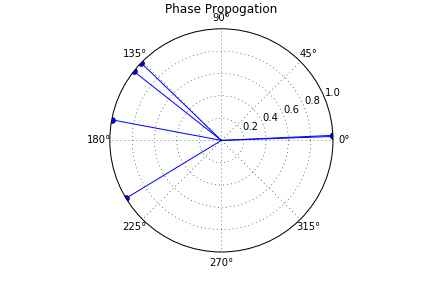

In [698]:
def animate():
    %matplotlib notebook
    import time
    import pylab as plt
    
    K = KModel()
    t_full = 10
    radii = np.ones(K.states[:,-1].shape)
    
    fig,ax = plt.subplots(1, 1, subplot_kw=dict(polar=True))
    ax.set_rmax(10)
    ax.set_title('Phase Propogation')
    for i in range(0,int(t_full/K.dt)):
        K.step()
        ax.lines = []
        ax.stem(K.states[:,-1],radii)
        fig.canvas.draw()
        if(K.dt > .06):
            time.sleep(K.dt-.06)
animate()
%matplotlib inline